In [ ]:
#!pip3 install -q mediapipe
#!pip3 install -q imageio
#!pip3 install -q sklearn
#!pip3 install -q torch

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [64]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# warning levels 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# "0" = all logs (default)
# "1" = filter out INFO
# "2" = filter out INFO + WARNING
# "3" = filter out INFO + WARNING + ERROR 

In [65]:
data_folder = '../data/videos/'
signs = ['hello', 'bye', 'world']

MODEL_PATH = "hand_landmarker.task"  

## Extract Keypoints

In [66]:
def extract_keypoints_for_signs(data_folder, signs, output_base):
    mp_holistic = mp.solutions.holistic

    # Número esperado de keypoints
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
    TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Cuerpo + 2 manos

    # Crear la carpeta base de salida
    os.makedirs(output_base, exist_ok=True)

    for sign in signs:
        video_folder = os.path.join(data_folder, sign)
        output_folder = os.path.join(output_base, sign)
        os.makedirs(output_folder, exist_ok=True)

        video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))]
        if not video_files:
            print(f"⚠️ No se encontraron videos para el signo '{sign}' en {video_folder}")
            continue

        print(f" 🍓 Signo '{sign}': {len(video_files)} videos encontrados. Procesando...")

        for video_name in video_files:
            video_path = os.path.join(video_folder, video_name)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"⚠️ No se pudo abrir el video: {video_name}")
                continue

            keypoints_list = []
            print(f" 🥭 Procesando: {video_name}")

            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)
                    keypoints = [(0, 0, 0)] * TOTAL_KEYPOINTS

                    if results.pose_landmarks:
                        for i, lm in enumerate(results.pose_landmarks.landmark):
                            keypoints[i] = (lm.x, lm.y, lm.z)

                    if results.left_hand_landmarks:
                        for i, lm in enumerate(results.left_hand_landmarks.landmark):
                            keypoints[POSE_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    if results.right_hand_landmarks:
                        for i, lm in enumerate(results.right_hand_landmarks.landmark):
                            keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    keypoints_list.append(keypoints)

                cap.release()

            if keypoints_list:
                keypoints_array = np.array(keypoints_list)
                output_path = os.path.join(output_folder, video_name.replace(".mp4", ".npy"))
                np.save(output_path, keypoints_array)
                print(f"✅ Keypoints guardados en {output_path}")
            else:
                print(f"⚠️ No se extrajeron keypoints para {video_name}")

    print("\n🎉 Proceso finalizado.")


In [67]:
output_main_folder = '../data/keypoints'
extract_keypoints_for_signs('../data/videos/', ['hello', 'bye', 'world'], output_main_folder)

 🍓 Signo 'hello': 29 videos encontrados. Procesando...
 🥭 Procesando: hello_20.mp4


I0000 00:00:1745686121.430328  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686121.492423 1249212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686121.500582 1249212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686121.503315 1249217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686121.503327 1249219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686121.503352 1249210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_20.npy
 🥭 Procesando: Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4


I0000 00:00:1745686122.412457  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686122.465356 1249242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.473304 1249244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.474436 1249253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.474436 1249246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.474462 1249242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.npy
 🥭 Procesando: hello_18.mp4


I0000 00:00:1745686122.927224  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686122.976825 1249278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.984854 1249277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.985937 1249286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.985950 1249281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686122.986510 1249279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_18.npy
 🥭 Procesando: hello_19.mp4


I0000 00:00:1745686124.031018  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686124.083466 1249307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686124.092374 1249307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686124.093348 1249315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686124.093416 1249312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686124.093574 1249317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_19.npy
 🥭 Procesando: hello_7.mp4


I0000 00:00:1745686125.117232  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686125.167611 1249341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686125.175631 1249341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686125.176539 1249348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686125.176688 1249344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686125.176705 1249343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_7.npy
 🥭 Procesando: hello_6.mp4


I0000 00:00:1745686126.353969  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686126.406428 1249376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686126.414784 1249376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686126.415806 1249382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686126.415837 1249378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686126.416426 1249386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_6.npy
 🥭 Procesando: Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4


I0000 00:00:1745686127.772268  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686127.824690 1249414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686127.832853 1249418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686127.833817 1249416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686127.833835 1249422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686127.834680 1249421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.npy
 🥭 Procesando: hello_4.mp4


I0000 00:00:1745686128.344643  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686128.395280 1249450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686128.403467 1249450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686128.404368 1249449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686128.404383 1249457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686128.404475 1249454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_4.npy
 🥭 Procesando: hello_5.mp4


I0000 00:00:1745686129.892433  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686129.943027 1249495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686129.951142 1249495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686129.952180 1249496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686129.952198 1249493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686129.952917 1249504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_5.npy
 🥭 Procesando: hello_1.mp4


I0000 00:00:1745686131.228755  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686131.279345 1249535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686131.287776 1249544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686131.288795 1249541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686131.288835 1249538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686131.289400 1249543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_1.npy
 🥭 Procesando: hello_2.mp4


I0000 00:00:1745686132.307883  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686132.360021 1249570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686132.367513 1249570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686132.368368 1249569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686132.368466 1249572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686132.368526 1249571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_2.npy
 🥭 Procesando: hello_3.mp4


I0000 00:00:1745686133.764108  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686133.813576 1249602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686133.822299 1249605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686133.823267 1249600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686133.823332 1249604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686133.823819 1249603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_3.npy
 🥭 Procesando: Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4


I0000 00:00:1745686135.127071  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686135.180531 1249630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686135.188625 1249637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686135.189671 1249630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686135.189674 1249632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686135.190234 1249634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.npy
 🥭 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4


I0000 00:00:1745686136.013588  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686136.068352 1249663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.076646 1249663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.077522 1249670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.077568 1249663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.077576 1249665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.npy
 🥭 Procesando: hello_8.mp4


I0000 00:00:1745686136.464353  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686136.516222 1249696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.525082 1249704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.526121 1249694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.526122 1249699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686136.526646 1249700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_8.npy
 🥭 Procesando: hello_9.mp4


I0000 00:00:1745686137.845001  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686137.898304 1249745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686137.906703 1249744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686137.907665 1249744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686137.907694 1249745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686137.907719 1249748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_9.npy
 🥭 Procesando: Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4


I0000 00:00:1745686139.389639  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686139.442485 1249776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.450461 1249778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.451463 1249781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.451518 1249779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.451564 1249776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.npy
 🥭 Procesando: hello_17.mp4


I0000 00:00:1745686139.733523  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686139.784194 1249798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.793069 1249798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.794002 1249799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.794107 1249800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686139.794705 1249807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_17.npy
 🥭 Procesando: hello_16.mp4


I0000 00:00:1745686140.604040  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686140.656081 1249824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686140.663723 1249824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686140.664637 1249828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686140.664691 1249829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686140.664727 1249831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_16.npy
 🥭 Procesando: Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4


I0000 00:00:1745686141.500864  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686141.550801 1249863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686141.559420 1249863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686141.560370 1249865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686141.560403 1249871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686141.560441 1249866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.npy
 🥭 Procesando: Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4


I0000 00:00:1745686142.125178  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686142.179522 1249894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686142.187247 1249903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686142.188162 1249895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686142.188245 1249893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686142.188266 1249897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.npy
 🥭 Procesando: hello_14.mp4


I0000 00:00:1745686143.315608  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686143.367824 1249922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686143.375987 1249928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686143.376942 1249924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686143.376988 1249921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686143.377009 1249920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_14.npy
 🥭 Procesando: hello_15.mp4


I0000 00:00:1745686144.327839  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686144.377843 1249948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686144.386213 1249955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686144.387094 1249949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686144.387245 1249948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686144.387951 1249955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_15.npy
 🥭 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4


I0000 00:00:1745686145.362468  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686145.413878 1249973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686145.422562 1249973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686145.423584 1249972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686145.423612 1249974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686145.423615 1249980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.npy
 🥭 Procesando: hello_11.mp4


I0000 00:00:1745686145.967297  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686146.019454 1250003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686146.028219 1250001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686146.028974 1250008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686146.029171 1250010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686146.030083 1250004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_11.npy
 🥭 Procesando: hello_10.mp4


I0000 00:00:1745686147.125644  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686147.179530 1250039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686147.188249 1250039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686147.189222 1250042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686147.189229 1250046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686147.189255 1250040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_10.npy
 🥭 Procesando: Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4


I0000 00:00:1745686148.729452  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686148.786136 1250068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686148.794831 1250076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686148.795794 1250066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686148.795806 1250070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686148.795830 1250069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.npy
 🥭 Procesando: hello_12.mp4


I0000 00:00:1745686149.313083  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686149.363746 1250094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686149.371825 1250103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686149.372866 1250101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686149.372867 1250095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686149.373543 1250098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_12.npy
 🥭 Procesando: hello_13.mp4


I0000 00:00:1745686150.329263  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686150.379087 1250160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686150.387229 1250165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686150.388180 1250164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686150.388278 1250160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686150.388299 1250163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_13.npy
 🍓 Signo 'bye': 29 videos encontrados. Procesando...
 🥭 Procesando: bye_19.mp4


I0000 00:00:1745686151.575278  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686151.627760 1250201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686151.636150 1250205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686151.637043 1250203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686151.637048 1250208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686151.637072 1250207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_19.npy
 🥭 Procesando: bye_18.mp4


I0000 00:00:1745686153.474299  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686153.524712 1250234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686153.533238 1250242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686153.534180 1250239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686153.534225 1250242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686153.534278 1250238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_18.npy
 🥭 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4


I0000 00:00:1745686155.120789  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686155.173088 1250263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686155.181191 1250263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686155.182182 1250261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686155.182232 1250269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686155.182240 1250271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.npy
 🥭 Procesando: bye_20.mp4


I0000 00:00:1745686156.207883  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686156.263815 1250292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686156.271145 1250298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686156.272153 1250297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686156.272181 1250290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686156.272201 1250293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_20.npy
 🥭 Procesando: bye_21.mp4


I0000 00:00:1745686157.673869  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686157.725846 1250353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686157.734391 1250351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686157.735358 1250353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686157.735471 1250358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686157.735475 1250356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_21.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.43.55.mov


I0000 00:00:1745686159.221223  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686159.276229 1250387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686159.284450 1250393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686159.285442 1250396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686159.285450 1250394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686159.285618 1250395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.43.55.mov
 🥭 Procesando: bye_8.mp4


I0000 00:00:1745686162.540463  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686162.595577 1250441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686162.603739 1250445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686162.604623 1250445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686162.604712 1250451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686162.604716 1250444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_8.npy
 🥭 Procesando: bye_9.mp4


I0000 00:00:1745686164.564203  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686164.617307 1250480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686164.626545 1250489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686164.627587 1250483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686164.627620 1250484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686164.628123 1250478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_9.npy
 🥭 Procesando: bye_4.mp4


I0000 00:00:1745686166.874066  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686166.931368 1250533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686166.939075 1250537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686166.939995 1250539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686166.940062 1250534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686166.940079 1250538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_4.npy
 🥭 Procesando: bye_5.mp4


I0000 00:00:1745686169.217684  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686169.269929 1250598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686169.278536 1250598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686169.279564 1250605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686169.279596 1250596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686169.280150 1250600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_5.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.44.25.mov


I0000 00:00:1745686171.548873  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686171.600625 1250643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686171.609069 1250643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686171.610094 1250647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686171.610161 1250649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686171.610676 1250643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.44.25.mov
 🥭 Procesando: bye_7.mp4


I0000 00:00:1745686174.760629  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686174.814457 1250687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686174.822915 1250686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686174.823993 1250687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686174.824037 1250686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686174.825041 1250696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_7.npy
 🥭 Procesando: bye_6.mp4


I0000 00:00:1745686176.732108  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686176.784527 1250720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686176.792831 1250720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686176.793786 1250726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686176.793854 1250718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686176.794044 1250724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_6.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.42.41.mov


I0000 00:00:1745686179.002273  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686179.054717 1250774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686179.063367 1250774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686179.064420 1250775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686179.064434 1250772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686179.064434 1250774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.42.41.mov
 🥭 Procesando: bye_2.mp4


I0000 00:00:1745686182.398027  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686182.452692 1250819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686182.461415 1250819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686182.462393 1250821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686182.462428 1250823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686182.462968 1250827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_2.npy
 🥭 Procesando: bye_3.mp4


I0000 00:00:1745686184.831861  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686184.890186 1250880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686184.897555 1250880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686184.898399 1250882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686184.898481 1250880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686184.898537 1250879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_3.npy
 🥭 Procesando: bye_1.mp4


I0000 00:00:1745686187.228961  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686187.283066 1250929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686187.290357 1250933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686187.291303 1250931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686187.291361 1250932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686187.291362 1250936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_1.npy
 🥭 Procesando: bye_10.mp4


I0000 00:00:1745686190.269395  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686190.322914 1250968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686190.331003 1250971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686190.332027 1250976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686190.332070 1250970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686190.332423 1250969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_10.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.45.38.mov


I0000 00:00:1745686192.368745  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686192.422502 1251024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686192.432728 1251024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686192.433672 1251032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686192.433689 1251027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686192.433874 1251028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.45.38.mov
 🥭 Procesando: bye_11.mp4


I0000 00:00:1745686195.904105  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686195.955854 1251069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686195.963321 1251071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686195.964247 1251072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686195.964282 1251073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686195.964337 1251076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_11.npy
 🥭 Procesando: Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4


I0000 00:00:1745686197.766041  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686197.817633 1251105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686197.825703 1251109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686197.826711 1251103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686197.826760 1251108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686197.827611 1251114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.44.52.mov


I0000 00:00:1745686199.116160  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686199.167301 1251144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686199.175888 1251144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686199.176825 1251151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686199.176892 1251149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686199.176922 1251144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.44.52.mov
 🥭 Procesando: bye_12.mp4


I0000 00:00:1745686202.607442  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686202.660466 1251204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686202.668805 1251209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686202.669744 1251204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686202.669848 1251210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686202.669864 1251213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_12.npy
 🥭 Procesando: bye_16.mp4


I0000 00:00:1745686204.511457  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686204.563014 1251239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686204.571640 1251242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686204.572649 1251241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686204.572677 1251237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686204.573246 1251238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_16.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.45.17.mov


I0000 00:00:1745686206.214657  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686206.266423 1251270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686206.275384 1251274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686206.276247 1251273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686206.276398 1251269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686206.276431 1251274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.45.17.mov
 🥭 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4


I0000 00:00:1745686210.145600  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686210.197777 1251325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686210.207331 1251325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686210.208491 1251324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686210.208595 1251327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686210.208611 1251329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.npy
 🥭 Procesando: bye_17.mp4


I0000 00:00:1745686211.054667  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686211.107710 1251389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686211.116450 1251392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686211.117292 1251396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686211.117315 1251398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686211.117417 1251393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_17.npy
 🥭 Procesando: bye_15.mp4


I0000 00:00:1745686213.235378  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686213.289118 1251435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686213.298307 1251444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686213.299340 1251443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686213.299389 1251441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686213.299389 1251437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_15.npy
 🥭 Procesando: bye_14.mp4


I0000 00:00:1745686214.726484  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686214.777544 1251461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686214.786268 1251461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686214.787221 1251468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686214.787261 1251460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686214.787277 1251471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_14.npy
 🍓 Signo 'world': 29 videos encontrados. Procesando...
 🥭 Procesando: Screen Recording 2025-03-17 at 19.51.51.mov


I0000 00:00:1745686216.611830  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686216.664055 1251493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686216.673318 1251493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686216.674346 1251491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686216.674385 1251496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686216.675082 1251502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.51.51.mov
 🥭 Procesando: world_19.mp4


I0000 00:00:1745686220.071493  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686220.124979 1251546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686220.134218 1251550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686220.135284 1251544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686220.135337 1251549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686220.135964 1251554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_19.npy
 🥭 Procesando: world_18.mp4


I0000 00:00:1745686221.751889  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686221.803773 1251590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686221.812825 1251590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686221.813810 1251601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686221.813810 1251599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686221.813841 1251591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_18.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.52.17.mov


I0000 00:00:1745686223.535322  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686223.587357 1251625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686223.595243 1251627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686223.596196 1251624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686223.596214 1251634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686223.596230 1251630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.52.17.mov
 🥭 Procesando: world_9.mp4


I0000 00:00:1745686226.791257  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686226.843318 1251677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686226.850830 1251685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686226.851765 1251677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686226.851873 1251685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686226.851878 1251678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_9.npy
 🥭 Procesando: world_20.mp4


I0000 00:00:1745686228.998727  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686229.052305 1251740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686229.060485 1251747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686229.061488 1251745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686229.061490 1251748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686229.061534 1251747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_20.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.52.38.mov


I0000 00:00:1745686230.623950  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686230.676861 1251768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686230.685467 1251768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686230.686547 1251774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686230.686615 1251775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686230.686619 1251778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.52.38.mov
 🥭 Procesando: world_8.mp4


I0000 00:00:1745686235.986792  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686236.042243 1251838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686236.050801 1251839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686236.051775 1251842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686236.051802 1251846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686236.051808 1251844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_8.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.50.29.mov


I0000 00:00:1745686237.687601  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686237.742938 1251875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686237.751144 1251875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686237.752173 1251882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686237.752201 1251878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686237.752220 1251873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.50.29.mov
 🥭 Procesando: Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4


I0000 00:00:1745686239.782332  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686239.834798 1251912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686239.843363 1251917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686239.844425 1251916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686239.844458 1251918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686239.844524 1251911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.51.21.mov


I0000 00:00:1745686241.283566  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686241.335625 1251951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686241.343817 1251959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686241.344738 1251954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686241.344750 1251949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686241.344820 1251957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.51.21.mov
 🥭 Procesando: Screen Recording 2025-03-17 at 19.49.49.mov


I0000 00:00:1745686242.922582  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686242.974408 1252003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686242.983073 1252007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686242.984095 1252004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686242.984154 1252003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686242.984813 1252005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.49.49.mov
 🥭 Procesando: world_5.mp4


I0000 00:00:1745686244.908905  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686244.961852 1252042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686244.970545 1252042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686244.971472 1252048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686244.971525 1252045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686244.972024 1252041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_5.npy
 🥭 Procesando: world_10.mp4


I0000 00:00:1745686246.872394  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686246.927005 1252075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686246.935804 1252084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686246.936701 1252082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686246.936858 1252080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686246.936882 1252085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_10.npy
 🥭 Procesando: world_11.mp4


I0000 00:00:1745686249.242894  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686249.295202 1252120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686249.304492 1252120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686249.305784 1252125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686249.305842 1252118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686249.305852 1252129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_11.npy
 🥭 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4


I0000 00:00:1745686251.196771  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686251.248513 1252154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686251.257210 1252154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686251.258167 1252161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686251.258170 1252151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686251.258194 1252157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.npy
 🥭 Procesando: world_4.mp4


I0000 00:00:1745686252.155698  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686252.218046 1252333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686252.228660 1252333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686252.229679 1252341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686252.229726 1252342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686252.229753 1252334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_4.npy
 🥭 Procesando: Screen Recording 2025-03-17 at 19.49.04.mov


I0000 00:00:1745686254.356970  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686254.409161 1252447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686254.418463 1252450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686254.419494 1252451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686254.419518 1252450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686254.419542 1252448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.49.04.mov
 🥭 Procesando: world_6.mp4


I0000 00:00:1745686257.002127  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686257.053801 1252487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686257.062142 1252497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686257.063209 1252491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686257.063292 1252493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686257.064449 1252498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_6.npy
 🥭 Procesando: world_13.mp4


I0000 00:00:1745686258.893831  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686368.070289 1252643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686368.083829 1252648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686368.085033 1252646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686368.085226 1252641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686368.085239 1252652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_13.npy
 🥭 Procesando: world_12.mp4


I0000 00:00:1745686369.999816  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686370.051177 1252998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686370.060019 1252999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686370.061095 1253004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686370.061177 1253005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686370.061234 1253007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_12.npy
 🥭 Procesando: world_7.mp4


I0000 00:00:1745686372.005392  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686372.058793 1253068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686372.066767 1253068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686372.067867 1253077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686372.067869 1253070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686372.067983 1253072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_7.npy
 🥭 Procesando: world_3.mp4


I0000 00:00:1745686373.706127  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686373.756587 1253128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686373.765744 1253135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686373.766725 1253131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686373.766775 1253135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686373.766812 1253130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_3.npy
 🥭 Procesando: world_16.mp4


I0000 00:00:1745686375.937287  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686375.991507 1253167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686376.000203 1253167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686376.001185 1253177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686376.001203 1253171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686376.001213 1253167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_16.npy
 🥭 Procesando: world_17.mp4


I0000 00:00:1745686377.855446  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686377.910023 1253197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686377.918770 1253197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686377.919773 1253206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686377.919833 1253200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686377.919868 1253201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_17.npy
 🥭 Procesando: world_2.mp4


I0000 00:00:1745686379.657298  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686379.711740 1253279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686379.720795 1253281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686379.721935 1253277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686379.722009 1253284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686379.722190 1253279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_2.npy
 🥭 Procesando: world_15.mp4


I0000 00:00:1745686382.153511  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686382.206385 1253317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686382.214883 1253317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686382.215884 1253327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686382.215913 1253318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686382.215948 1253317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_15.npy
 🥭 Procesando: world_14.mp4


I0000 00:00:1745686384.034564  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686384.087994 1253363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686384.096493 1253363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686384.097367 1253361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686384.097398 1253363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686384.097474 1253358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_14.npy
 🥭 Procesando: world_1.mp4


I0000 00:00:1745686385.870399  961659 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745686385.922541 1253392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686385.931530 1253392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686385.932549 1253396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686385.932576 1253393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745686385.932597 1253395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_1.npy

🎉 Proceso finalizado.


## Data augmentation

In [68]:
# Paths
input_folder = "../data/keypoints"
output_folder = "../data/keypoints_augmented"

# Parameters
signs = ["hello", "bye", "world"]
augmentations_per_sample = 10  # Create 10 variations per sample
SEQUENCE_LENGTH = 30

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for sign in signs:
    input_sign_folder = os.path.join(input_folder, sign)
    output_sign_folder = os.path.join(output_folder, sign)
    os.makedirs(output_sign_folder, exist_ok=True)

    for filename in os.listdir(input_sign_folder):
        if not filename.endswith(".npy"):
            continue

        filepath = os.path.join(input_sign_folder, filename)
        sequence = np.load(filepath)

        # Save original
        output_path = os.path.join(output_sign_folder, filename)
        np.save(output_path, sequence)

        # Generate augmentations
        for i in range(augmentations_per_sample):
            aug_sequence = sequence.copy()

            # Add random Gaussian noise
            noise = np.random.normal(0, 0.01, aug_sequence.shape)
            aug_sequence += noise

            # Randomly time shift (small roll of frames)
            shift = np.random.randint(-2, 3)
            aug_sequence = np.roll(aug_sequence, shift=shift, axis=0)

            # Optional: Random slight scaling
            scale = np.random.uniform(0.9, 1.1)
            aug_sequence *= scale

            # Save augmented sequence
            aug_filename = filename.replace(".npy", f"_aug{i}.npy")
            aug_output_path = os.path.join(output_sign_folder, aug_filename)
            np.save(aug_output_path, aug_sequence)

## Generate train test data

In [69]:
SEQUENCE_LENGTH = 30  # Fixed number of frames

def load_dataset(signs, keypoints_root):
    sequences = []
    labels = []

    for sign in signs:
        sign_folder = os.path.join(keypoints_root, sign)
        if not os.path.exists(sign_folder):
            print(f"⚠️ Folder not found: {sign_folder}")
            continue

        for filename in os.listdir(sign_folder):
            if not filename.endswith(".npy"):
                continue

            file_path = os.path.join(sign_folder, filename)
            sequence = np.load(file_path)

            # Handle expected shape: (T, 75, 3)
            if len(sequence.shape) != 3 or sequence.shape[1:] != (75, 3):
                print(f"⚠️ Skipping {file_path}: unexpected shape {sequence.shape}")
                continue

            # Flatten per frame → (T, 225)
            sequence = sequence.reshape(sequence.shape[0], -1)

            # Pad or truncate to fixed length
            if sequence.shape[0] < SEQUENCE_LENGTH:
                pad_width = SEQUENCE_LENGTH - sequence.shape[0]
                sequence = np.pad(sequence, ((0, pad_width), (0, 0)), mode='constant')
            else:
                sequence = sequence[:SEQUENCE_LENGTH]

            sequences.append(sequence)
            labels.append(sign)

    if not sequences:
        raise ValueError("❌ No valid sequences were loaded. Please check your input files.")

    # Convert to numpy arrays
    X = np.array(sequences)  # shape: (num_samples, SEQUENCE_LENGTH, 225)
    y = np.array(labels)

    # Encode labels to integers
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    # Normalize keypoints
    X_mean = X.mean(axis=(0, 1))
    X_std = X.std(axis=(0, 1)) + 1e-6
    X_normalized = (X - X_mean) / X_std

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_normalized, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    print(f"✅ Dataset ready! Train: {X_train.shape}, Val: {X_val.shape}")
    print(f"Classes: {encoder.classes_}")

    return X_train, X_val, y_train, y_val, encoder, X_mean, X_std


In [70]:
signs = ["hello", "bye", "world"]
keypoints_folder = "../data/keypoints"
#keypoints_folder = "../data/keypoints_augmented"
X_train, X_val, y_train, y_val, label_encoder, X_mean, X_std = load_dataset(signs, keypoints_folder)

✅ Dataset ready! Train: (69, 30, 225), Val: (18, 30, 225)
Classes: ['bye' 'hello' 'world']


In [71]:
# guardamos label_encoder para implementarlo en la app 
with open("../app/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [72]:
# guardamos keypoint normalization parameters para app 
scaler = {"mean": X_mean, "std": X_std}

with open("../app/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [73]:
from collections import Counter
print(Counter(y_train))


Counter({0: 23, 2: 23, 1: 23})


## modelo lstm en pytorch

In [74]:
# Parámetros
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = len(label_encoder.classes_)
INPUT_SIZE = X_train.shape[2]
SEQUENCE_LENGTH = X_train.shape[1]

# Dataset y DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Modelo LSTM

class SignLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, num_classes=NUM_CLASSES):
        super(SignLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # output: (batch, seq_len, hidden_size)
        # hn: (num_layers, batch, hidden_size)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  # usamos la última capa
        return out


model = SignLSTM(INPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [75]:
# entrenamiento del modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"📚 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Val Accuracy: {100*correct/total:.2f}%")


📚 Epoch 1/30 | Loss: 2.8834 | Val Accuracy: 66.67%
📚 Epoch 2/30 | Loss: 2.1568 | Val Accuracy: 66.67%
📚 Epoch 3/30 | Loss: 1.7842 | Val Accuracy: 61.11%
📚 Epoch 4/30 | Loss: 1.5133 | Val Accuracy: 66.67%
📚 Epoch 5/30 | Loss: 1.2998 | Val Accuracy: 94.44%
📚 Epoch 6/30 | Loss: 0.8660 | Val Accuracy: 88.89%
📚 Epoch 7/30 | Loss: 0.9013 | Val Accuracy: 88.89%
📚 Epoch 8/30 | Loss: 0.8634 | Val Accuracy: 88.89%
📚 Epoch 9/30 | Loss: 0.8404 | Val Accuracy: 83.33%
📚 Epoch 10/30 | Loss: 0.5726 | Val Accuracy: 66.67%
📚 Epoch 11/30 | Loss: 0.8331 | Val Accuracy: 77.78%
📚 Epoch 12/30 | Loss: 0.4585 | Val Accuracy: 88.89%
📚 Epoch 13/30 | Loss: 0.4115 | Val Accuracy: 88.89%
📚 Epoch 14/30 | Loss: 0.3761 | Val Accuracy: 88.89%
📚 Epoch 15/30 | Loss: 0.3081 | Val Accuracy: 83.33%
📚 Epoch 16/30 | Loss: 0.3400 | Val Accuracy: 83.33%
📚 Epoch 17/30 | Loss: 0.2026 | Val Accuracy: 88.89%
📚 Epoch 18/30 | Loss: 0.1814 | Val Accuracy: 94.44%
📚 Epoch 19/30 | Loss: 0.1514 | Val Accuracy: 94.44%
📚 Epoch 20/30 | Loss:

In [76]:
# guardamos el modelo para implementarlo en la app 
torch.save(model.state_dict(), "../app/model.pth")

## Validación 

In [77]:
# Accuracy Score

from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")

✅ Validation Accuracy: 88.89%


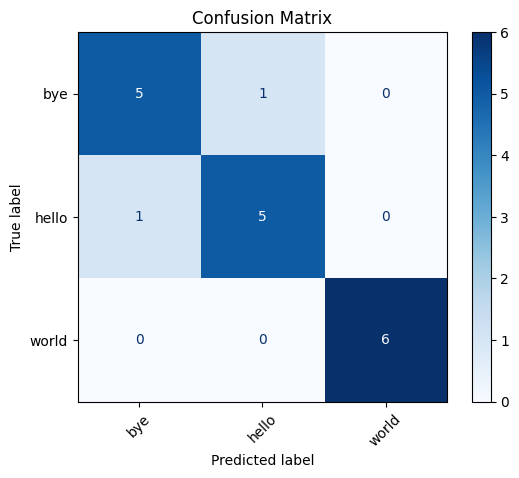

In [78]:
# confussion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [63]:
# Precision, Recall, F1 Score

from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

         bye       1.00      1.00      1.00        42
       hello       1.00      1.00      1.00        42
       world       1.00      1.00      1.00        42

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126

